In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import distance
# !pip install gsw
from gsw.conversions import CT_from_pt
from gsw.density import sigma2
import matplotlib.pyplot as plt

In [2]:
home = "/mnt/g/My Drive/GTC/solodoch_data_full/60S"

In [3]:
# get monthly mean velocity
vm = xr.open_mfdataset(f"{home}/ECCO_L4_OCEAN_VEL_05DEG_MONTHLY_V4R4/*nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
vm = vm[["NVEL"]].transpose("longitude", "latitude", "Z", "time")
vm = vm.rename({"NVEL": "vm"})

# get bolus velocity
ve = xr.open_mfdataset(f"{home}/ECCO_L4_BOLUS_05DEG_MONTHLY_V4R4/*nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
ve = ve[["NVELSTAR"]].transpose("longitude", "latitude", "Z", "time")
ve = ve.rename({"NVELSTAR": "ve"})

# inner join
data = xr.merge([vm, ve], join="inner")
lat = data["latitude"].to_numpy()[0]
lons = data["longitude"].to_numpy()
# flip depth axis because we integrate from the bottom up
Z = np.flip(data["Z"].to_numpy())[:-1]
# get distance between each lat/lon in meters
coords = [(lat, lon) for lon in lons]
d_lon = [distance(coords[i-1], coords[i]).meters for i in range(1, len(coords))]
# get distance bewteen each depth measurement
d_z = np.diff(np.flip(data["Z"].to_numpy()))
# this is just necessary because I haven't downloaded all the times yet - I need to subset temp/salinity
times = data["time"].to_numpy()
start = min(times)
end = max(times)
# convert to numpy to make life easier
vm = data["vm"].to_numpy(); vm = np.nan_to_num(vm)
ve = data["ve"].to_numpy(); ve = np.nan_to_num(ve)
# remember to flip depth axis - axis order is given by the transpose operations above
vm = np.flip(vm, axis=2)
ve = np.flip(vm, axis=2)
# add monthly mean velocity and bolus velocity 
v = vm + ve
# after calculating d_lon and d_z we have to chop off the ends of these axes
v = v[:-1, :, :-1, :]

In [4]:
# open potential temperature and absolute salinity - needed to calculate sigma_2 -> isopycnals
data = xr.open_mfdataset(f"{home}/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
data = data[["SALT", "THETA"]]
# subsetting times I have downloaded
data = data.sel(time=times)
pt = data["THETA"].to_numpy().squeeze()
sa = data["SALT"].to_numpy().squeeze()
# convert potential temperature to conservative temperature - needed for the next function
ct = CT_from_pt(sa, pt)
# calculates sigma_2 (potential density at 2000 decibars) from absolute salinity and conservative temperature
density = sigma2(sa, ct)
# flip depth axis 
density = np.flip(density, axis=1)[:, :-1, :-1]

In [5]:
def psi(dens: float) -> np.ndarray:
    """
    calculate the streamfunction time series given a particular potential density
    see solodoch et al., 2023 2.2 for calculation
    dens: density for which we want to calculate isopycnal depths
    """
    # isopycnals are particular depths for every longitude at a given point in time
    isopycnals = np.zeros((density.shape[0], density.shape[2]))
    for t in range(isopycnals.shape[0]):
        for lon in range(isopycnals.shape[1]):
            column = density[t, :, lon]
            # we want to find the depth at which the density is closest to dens
            ix = np.argmin(np.abs(column - dens))
            isopycnals[t, lon] = Z[ix]

    # we now perform the double integral
    n_lons, n_lats, n_depths, n_times = v.shape
    inner_integral = np.zeros((n_lons, n_lats, n_times))
    for t in range(n_times):
        # NOTE: I covinced myself that I need to add one here, but someone should check this.
        # need to find how many depth "cells" we are going to sum over
        ixs = [list(Z).index(d)+1 for d in isopycnals[t]]
        for lon in range(n_lons):
            v_lon = v[lon, :, :ixs[lon], t]
            d_z_lon = d_z[:ixs[lon]]
            inner_integral[lon, :, t] = np.tensordot(v_lon, d_z_lon, axes=([1], [0]))
    outer_integral = np.tensordot(inner_integral, d_lon, axes=([0], [0]))
    out = -outer_integral.squeeze() / 1e6
    return out

In [6]:
# this controls how many pieces we discretise the density grid into
# more obviously means a more precise result, but longer computation time
density_precision = 100

density_range = density.flatten()
density_range = density_range[~np.isnan(density_range)]
density_discrete = np.linspace(min(density_range), max(density_range), density_precision)

# calculate the streamfunction for every density
streamfunction = [psi(d) for d in density_discrete]
streamfunction = np.vstack(streamfunction)
# find the density which gives the largest absolute time-meaned streamfunction value
sigma_2_0 = np.argmax(abs(np.mean(streamfunction, axis=1)))
sigma_2_0 = density_discrete[sigma_2_0]
# now use this really special important density 
moc_strength = psi(sigma_2_0)
# multiply by the sign
sign = (np.mean(moc_strength) > 0) * 2. - 1
moc_strength *= sign

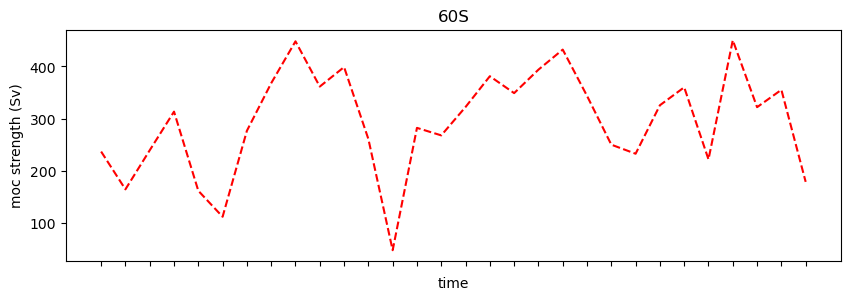

In [9]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(moc_strength, color="red", linestyle="--")
ax.set_xlabel("time"); ax.set_ylabel("moc strength (Sv)")
ax.set_title("60S")
ax.set_xticks(np.arange(30), [])
plt.show()